In [2]:
import sys
import warnings
sys.path.append("../Pythonscripts")
sys.path.append(r"C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\Scripts")
import pandas as pd
import numpy as np
import synapseclient as sc
from pdkit_features import pdkit_normalize
warnings.simplefilter("ignore")
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pymatch.Matcher import Matcher

%matplotlib inline

In [3]:
year = datetime.now().year

In [4]:
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [5]:
def plot_distribution(data):
    male_PD = data[(data["PD"] == 1) & (data["sex"] == "male")]["age"]
    male_NONPD = data[(data["PD"] == 0) & (data["sex"] == "male")]["age"]
    female_PD = data[(data["PD"] == 1) & (data["sex"] == "female")]["age"]
    female_NONPD = data[(data["PD"] == 0) & (data["sex"] == "female")]["age"]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    sns.distplot(male_PD, label = "PD", kde_kws={"shade": True}, hist = True, ax = axes[0])
    sns.distplot(male_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = True, ax = axes[0])
    sns.distplot(female_PD, label = "PD", kde_kws={"shade": True}, hist = True, ax = axes[1])
    sns.distplot(female_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = True, ax = axes[1])
    axes[0].set_title("p-values: {}".format(ttest_ind(male_PD, male_NONPD)[1]))
    axes[0].grid()
    axes[1].set_title("p-values: {}".format(ttest_ind(female_PD, female_NONPD)[1]))
    axes[1].grid()
    plt.show()

# Query Synapse Data

In [13]:
## grouped walking data 
## use where recordIds are more than 5
## one to one matching

## group by
grouped = syn.tableQuery("SELECT healthCode, count(recordId) \
                         as nrecords FROM syn12514611 GROUP BY healthCode")
grouped = grouped.asDataFrame().dropna().reset_index(drop = True)
grouped = grouped[grouped["nrecords"] >= 5]


## query walking data
data = syn.tableQuery("SELECT DISTINCT healthCode, birthYear, sex, diagnosis  FROM syn15673379") 
data = data.asDataFrame().dropna().reset_index(drop = True)
data = pd.merge(grouped, data, how = "inner", on = "healthCode")

## featurize and map function
data["age"] = (data["birthYear"].apply(lambda year: datetime.now().year - year))
data["PD"]  = (data["diagnosis"].map({"control":0, "parkinsons":1}))
data = data[(data["sex"] == "male") | (data["sex"] == "female")]
data = data.drop(["birthYear", "diagnosis"], axis = 1)

# Current Distribution

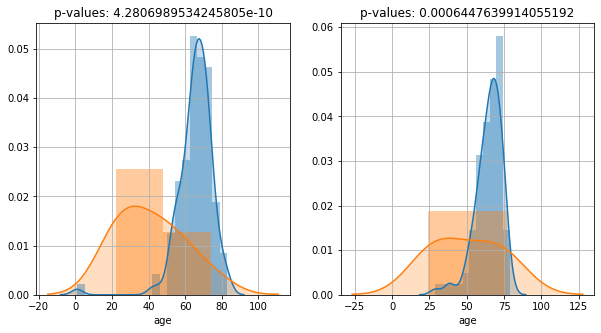

number of healthcode 222


In [14]:
plot_distribution(data)
print("number of healthcode {}".format(data.shape[0]))

In [15]:
## pseudocode 

## separate gender into male and female
## for each control find a corresponding case with the same age

def case_matching(data, gender, case):
    data = data[data["sex"] == gender]
    controls = data[data["PD"] == 0]
    cases = data[data["PD"] == 1]
    gender_separated_data =  pd.merge(controls, cases, how = "inner", on = "age")
    gender_separated_data["nrecords_total"] = gender_separated_data["nrecords_x"] + gender_separated_data["nrecords_y"]
    data = pd.DataFrame()
    for healthcode in gender_separated_data.healthCode_x.unique():
        temp = gender_separated_data[gender_separated_data["healthCode_x"] == healthcode]
        temp = temp.sort_values(by = ["nrecords_total"], ascending=False).head(case)
        data = pd.concat([data, temp])
    return data
    

def fix_columns(male_data, female_data):

    male_left = male_data[["healthCode_x", 
                   "age", 
                   "sex_x", 
                   "PD_x",
                  "nrecords_x"]].rename(columns = {"healthCode_x": "healthCode",
                                                    "sex_x":"sex",
                                                    "nrecords_x": "nrecords",
                                                    "PD_x":"PD"})
    male_right = male_data[["healthCode_y", "age", "sex_y", "PD_y","nrecords_y"]].rename(columns = {"healthCode_y": "healthCode",
                                                                            "sex_y":"sex",
                                                                              "nrecords_y": "nrecords",
                                                                            "PD_y":"PD"})

    female_left = female_data[["healthCode_x", "age", "sex_x", "PD_x","nrecords_x"]].rename(columns = {"healthCode_x": "healthCode",
                                                                                "sex_x":"sex",
                                                                                  "nrecords_x": "nrecords",
                                                                                "PD_x":"PD"})
    female_right = female_data[["healthCode_y", "age", "sex_y", "PD_y","nrecords_y"]].rename(columns = {"healthCode_y": "healthCode",
                                                                                "sex_y":"sex",
                                                                                  "nrecords_y": "nrecords",
                                                                                "PD_y":"PD"})

    filt_healthcode = pd.concat([male_left,male_right, female_left, female_right]).drop_duplicates(keep = "first").reset_index(drop = True)
    return filt_healthcode

# One-One Individual Case Matching

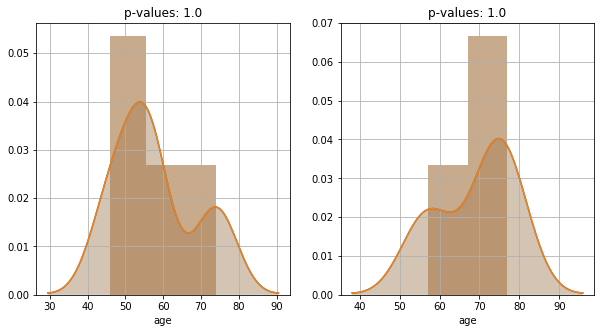

number of healthcode 14


In [16]:
## one to one relationship of case and control

one_one_male_data    = case_matching(data, "male"  , 1)
one_one_female_data  = case_matching(data, "female", 1)
one_one_case_matched = fix_columns(one_one_male_data, one_one_female_data)
plot_distribution(one_one_case_matched)
print("number of healthcode {}".format(one_one_case_matched.shape[0]))

# One Control - Two Cases Individual Matching

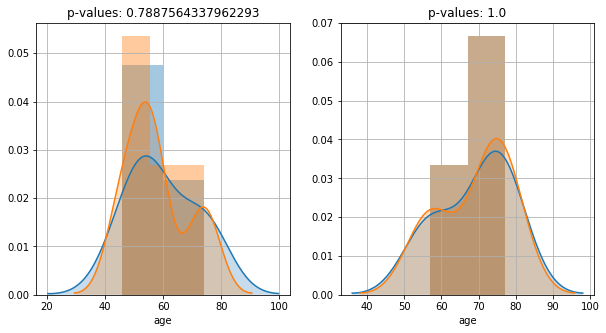

number of healthcode 19


In [17]:
## 2:1 relationship case vs control (case:control)

one_two_male_data    = case_matching(data, "male"  , 2)
one_two_female_data  = case_matching(data, "female", 2)
one_two_case_matched = fix_columns(one_two_male_data, one_two_female_data)
plot_distribution(one_two_case_matched)
print("number of healthcode {}".format(one_two_case_matched.shape[0]))

# Matching using pymatch

In [97]:
np.random.seed(100)
is_case_mask = data["PD"] == 1
male_data = data[data["sex"] == "male"]


case = male_data[male_data["PD"] == 1]
control = male_data[~(male_data["PD"] == 1)]

In [98]:
m = Matcher(test = case, control = control, yvar= "PD", exclude=["healthCode", "nrecords", "sex"])

Formula:
PD ~ age
n majority: 116
n minority: 9


In [99]:
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 84.83%


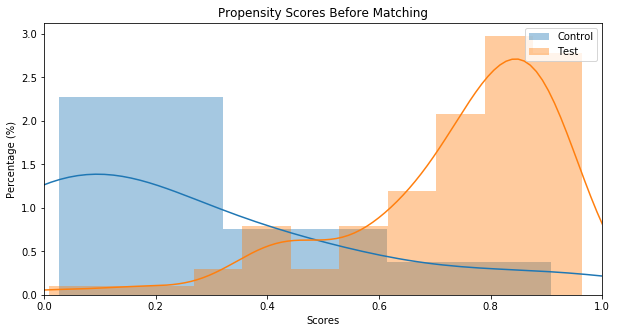

In [100]:
m.predict_scores()
m.plot_scores()

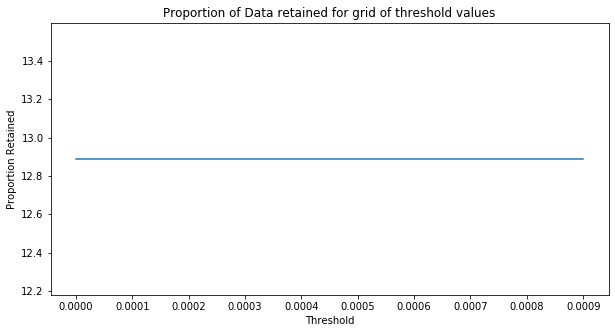

In [93]:
m.tune_threshold(method='min')

In [86]:
m.match(method="min", nmatches=1, threshold=0.0001)

In [87]:
m.record_frequency()

,freq,n_records
0,1,119
1,11,1
2,23,1
3,79,1


In [88]:
m.assign_weight_vector()

In [89]:
m.matched_data.sort_values("match_id")

,record_id,weight,healthCode,nrecords,sex,age,PD,scores,match_id
0,0,1.000000,0028d250-393f-4fa7-b203-0d8ec7c5137a,12,male,63.0,1,0.702347,0
208,123,0.043478,ad6f0097-face-480d-b2bf-d02dede755a1,7,male,57.0,0,0.511472,0
118,120,0.090909,6670ea5b-43e6-4b40-b3bb-c4dfae4be137,23,male,54.0,0,0.413130,1
1,1,1.000000,00f7565d-0b8f-4c7d-9534-5166ef81288a,5,male,55.0,1,0.445239,1
2,2,1.000000,03366c61-0e20-4afd-973c-4f0a5685385d,51,male,65.0,1,0.755518,2
129,122,0.012658,87af37ab-2f76-4860-974d-572653de4858,13,male,74.0,0,0.906742,2
3,3,1.000000,0b37cf92-1895-44a8-b9fc-6f970d76afa6,7,male,72.0,1,0.884198,3
130,122,0.012658,87af37ab-2f76-4860-974d-572653de4858,13,male,74.0,0,0.906742,3
4,4,1.000000,0c8e6b11-3be6-44d7-9ed9-16d574fde367,10,male,70.0,1,0.856039,4
131,122,0.012658,87af37ab-2f76-4860-974d-572653de4858,13,male,74.0,0,0.906742,4


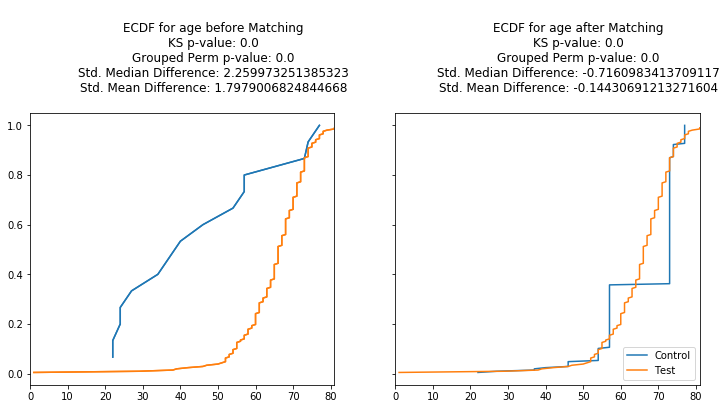

In [60]:
cc = m.compare_continuous(return_table=True)

In [61]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.0,0.0,0.0,2.259973,-0.716098,1.797901,-0.144307
